<a href="https://colab.research.google.com/github/FaizalSandanampusi/EIP/blob/master/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import load_model
from keras.datasets import cifar10
import keras
from keras.layers import Conv2D
import numpy as np
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2,l1
from keras import backend as K
from keras.layers import Activation, GlobalAveragePooling2D,GlobalMaxPooling2D,Dense
from keras.optimizers import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing import image
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

Using TensorFlow backend.


In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#mean_image = np.mean(x_train, axis=0)
#x_train -= mean_image
#x_test -= mean_image
x_train /= 255
x_test /= 255


In [3]:
!git clone https://github.com/qubvel/classification_models.git

fatal: destination path 'classification_models' already exists and is not an empty directory.


In [5]:
from classification_models.classification_models.resnet import ResNet18, preprocess_input
base_model = ResNet18((32, 32, 3), weights='imagenet',include_top=False)

W0710 14:38:42.046684 139916783966080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 14:38:42.089274 139916783966080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 14:38:42.090480 139916783966080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0710 14:38:42.095850 139916783966080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0710 14:38:42.099906 139916

In [0]:
x=base_model.output
x=Conv2D(128, (1,1), strides=(1,1), padding='valid', name='conv_flat', use_bias=False,kernel_initializer="glorot_normal",kernel_regularizer=l2(5e-4))(x)
x=Conv2D(10, (1,1), strides=(1,1), padding='valid', name='conv_flat1', use_bias=False,kernel_initializer="glorot_normal",kernel_regularizer=l2(5e-4))(x)
x=GlobalAveragePooling2D()(x)
output = Activation('softmax')(x)
model=Model(inputs=base_model.input,outputs=output)

In [7]:
model.summary()
for layer in model.layers[:]:
    layer.trainable=True

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

In [8]:
adm=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=adm,loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=256,
          epochs=1,
          validation_data=(x_test, y_test),
          shuffle=True
          )

W0710 14:38:49.358534 139916783966080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0710 14:38:49.538503 139916783966080 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 36s 712us/step - loss: 1.0273 - acc: 0.6875 - val_loss: 0.8496 - val_acc: 0.7429


In [0]:
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)
class_output= model.output[:, pred_digits[0]]
last_conv_layer = model.get_layer("stage2_unit1_conv1")
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x_test])

for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

In [0]:
mis_class=[]
prop_class=[]
for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==50):
        break

i=0

for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==100):
        break

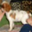

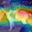

-1

In [177]:
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
from keras.preprocessing.image import array_to_img
# load the image
pil_img = array_to_img(test_features[12]).convert('RGB') 
cvimg = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
heatmap = cv2.resize(heatmap, (cvimg.shape[1], cvimg.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(cvimg, 0.6, heatmap, 0.4, 0)
cv2_imshow(cvimg)
cv2_imshow(superimposed_img)
cv2.waitKey(0)

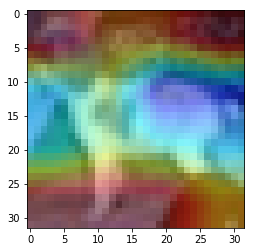

In [178]:
plt.imshow(superimposed_img)  

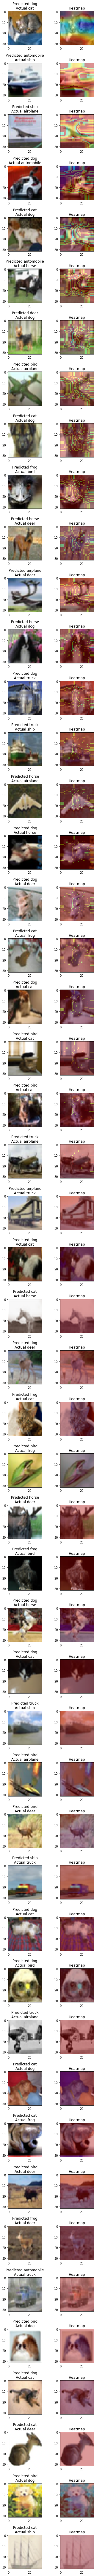

In [184]:
fig,ax=plt.subplots(50,2)
fig.set_size_inches(5,120)
l=0
for i in range(50):
    for j in range (1):
        k=j
        #l=rn.randint(0,len(pred_digits))
        pil_img = array_to_img(x_test[mis_class[l]]).convert('RGB')
        cvimg = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
        heatmap = cv2.resize(heatmap, (cvimg.shape[1], cvimg.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(cvimg, 0.6, heatmap, 0.4, 0)
        cv2.imwrite("/content/Gradcam_result/heatmap"+str(l)+".jpg",superimposed_img)
        ax[i,j].imshow(x_test[mis_class[l]])
        #ax[i,k+1].imshow(heatmap)
        ax[i,k+1].imshow(superimposed_img)
        x="Predicted " + str(class_names[pred_digits[mis_class[l]]]) + "\nActual " + str(class_names[test_labels[mis_class[l]][0]])
        ax[i,j].set_title(x)
        ax[i,k+1].set_title("Heatmap")
        l+=1

plt.tight_layout()

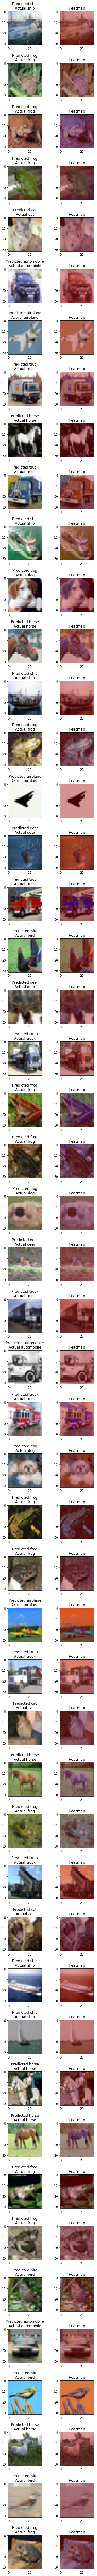

In [168]:
fig,ax=plt.subplots(50,2)
fig.set_size_inches(5,120)
l=0
for i in range(50):
    for j in range (1):
        k=j 
        #l=rn.randint(0,len(pred_digits))
        pil_img = array_to_img(x_test[prop_class[l]]).convert('RGB')
        cvimg = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
        heatmap = cv2.resize(heatmap, (cvimg.shape[1], cvimg.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(cvimg, 0.6, heatmap, 0.4, 0)
        ax[i,j].imshow(x_test[prop_class[l]])
        ax[i,k+1].imshow(superimposed_img)
        x="Predicted " + str(class_names[pred_digits[prop_class[l]]]) + "\nActual " + str(class_names[test_labels[prop_class[l]][0]])
        ax[i,j].set_title(x)
        ax[i,k+1].set_title("Heatmap")
        l+=1

plt.tight_layout()